**Penjelasan singkat mengenai pipeline implementasi**

Penyelesaian kasus Spam Filtering yang dibuat menggunakan metode ensemble learning. Secara sederhana, ensemble learning menggunakan lebih dari satu algoritma klasifikasi (dalam kasus ini LSTM, DNN, dan SVM) untuk melakukan prediksi suatu kelas. Ada beberapa pendekatan yang bisa dilakukan untuk mendapatkan kelasnya, yang digunakan saat ini adalah metode voting, dimana kelas yang paling sering muncul dari ketiga algoritma tersebut yang akan diambil.


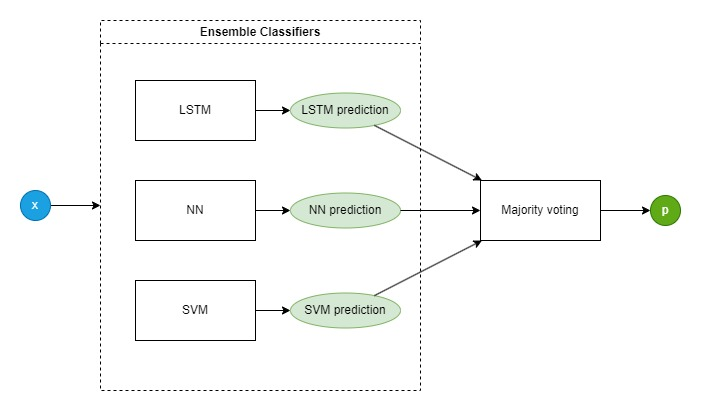

**Pipeline**

1. Dataset dibagi menjadi 2 bagian, pertama data latih yang digunakan untuk initial train model, kedua data test yang terdiri dari isi email saja tanpa kelas dan dibagi menjadi beberapa bagian. Data test ini nantinya digunakan dalam proses incremental learning model ensemble.
2. Preprocessing data: dilakukan data cleansing dan vectorization kata
3. Proses training model dilakukan dengan cara melakukan training pada seluruh algoritma klasifikasi yang menyusun ensemble learning.
4. Proses prediksi, sebagaimana dijelaskan di atas, dilakukan dengan cara voting terhadap kelas terbanyak yang muncul dari algoritma-algoritma yang menyusun ensemble learning. Setelah didapatkan kelasnya, data ini digabungkan dengan data latih sebelumnya yang kemudian digunakan dalam melatih model kembali.
5. Proses training dan prediksi dilakukan terus menerus hingga tidak ada data yang bisa diprediksi lagi.

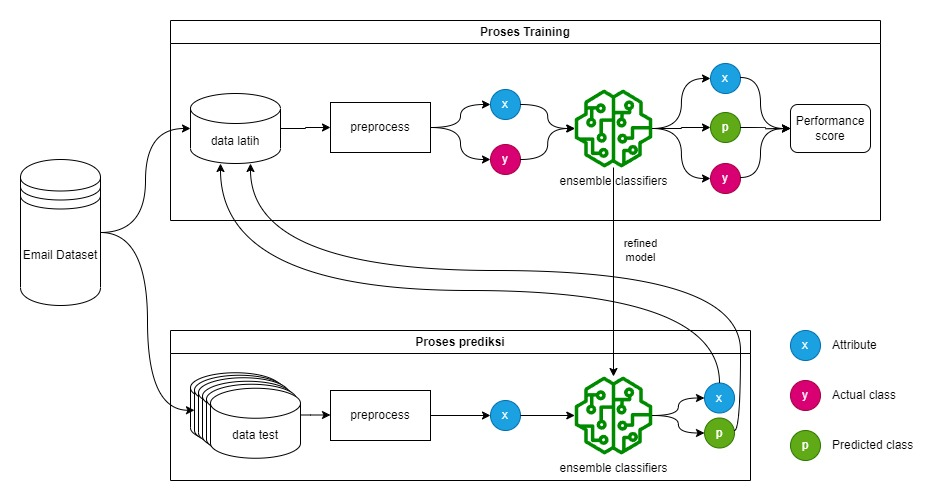

# Read data

Bagian ini digunakan untuk melakukan import dataset serta menyesuaikan nama dan tipe kolom

## EnronSpam

Dataset ini didapat dari (http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/index.html). Berisi beragam email dengan perbandingan yang hampir sama (50:50).

note: dataset yang diimport ke colab ini sudah dilakukan parsing ke csv. Hasilnya bisa didownload di [sini](https://drive.google.com/drive/folders/1s5GNI1f6JS6DafSTPzSkI6DOwjtpUxng?usp=drive_link)



In [2]:
import pandas as pd

df_raw = pd.DataFrame()

for i in range(1,7):
  temp = pd.read_csv('../../Datasets/EnronSpam/EnronSpam{}.csv'.format(i))
  df_raw = pd.concat([df_raw, temp], ignore_index=True)

df_raw.rename(columns={'email': 'text'}, inplace=True)
df_raw

,text,label
0,Subject: eastrans nomination change effective ...,0
1,Subject: re : personal information needs to be...,0
2,Subject: re : saudi arabia\r\ni spoke to mr . ...,0
3,"Subject: hpl nom for may 24 , 2001\r\n( see at...",0
4,"Subject: re : error repairs\r\njay ,\r\nfor ju...",0
...,...,...
33711,Subject: ` shoot bucket loads of sperm\r\nlncr...,1
33712,"Subject: ' the antidote '\r\nhello ,\r\nwe hav...",1
33713,Subject: we have top - selling rxdrugs for you...,1
33714,Subject: re : thhe problem solved\r\ndear sir ...,1


In [2]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    33716 non-null  object
 1   label   33716 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 526.9+ KB


In [3]:
df_raw['label'].value_counts(normalize=True)

label
1    0.509283
0    0.490717
Name: proportion, dtype: float64

### Adjust distribution

Karena distribusi 50:50 tidak realistis, maka dataset direkayasa agar jumlah non-spam lebih banyak daripada spam

In [4]:
label0 = df_raw[df_raw['label'] == 0]
label1 = df_raw[df_raw['label'] == 1].sample(frac=0.3, random_state=42)

In [5]:
df = pd.concat([label0, label1], ignore_index=True)
df['label'].value_counts(normalize=True)

label
0    0.762583
1    0.237417
Name: proportion, dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21696 entries, 0 to 21695
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21696 non-null  object
 1   label   21696 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 339.1+ KB


Output dari kode dibawah didapatkan dari dataset Text Spam

# Preprocess

## Clean text

Proses cleansing yang telah dilakukan antara lain menghilangkan angka, lowercase, menghilangkan newline character (\r\n), menghapus stopwords (stopwords didapatkan dari corpus NLTK), stemming menggunakan SnowballStemmer. Hasil akhir setelah cleansing berupa string.

In [7]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.stem.snowball import EnglishStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re

def remove_punctuation(text):
  return text.translate(str.maketrans('', '', string.punctuation))

def remove_number(text):
  return text.translate(str.maketrans('', '', string.digits))

def remove_stopword(tokens):
  stop_words = set(stopwords.words('english'))
  clean_tokens = []
  for token in tokens:
    if token not in stop_words:
      clean_tokens.append(token)
  return clean_tokens

def stem(tokens):
  stemmer = EnglishStemmer()
  stemmed = [stemmer.stem(token) for token in tokens]
  return stemmed

def remove_new_line_character(tokens):
  res = []
  for token in tokens:
    res.append(token.replace('\r\n', ''))
  return res

def preprocess(text):
  text = remove_number(text)
  text = text.lower()
  text = remove_punctuation(text)
  tokens = word_tokenize(text)
  tokens = remove_stopword(tokens)
  tokens = stem(tokens)
  result = " ".join(tokens).strip()
  return result

In [9]:
df['text'][0]

'Subject: eastrans nomination change effective 9 / 8 / 00\r\nplease decrease deliveries to eastrans to 0 mmbtu / dy for 9 / 8 / 00\r\nthe redeliveries will be 0 as well .\r\nthe over - delivery quantity for the fuels cotton valley gas will be valued per\r\nparagraph 3 of the contract price ( per mmbtu ) section in the transaction\r\nagreement .'

In [10]:
df['text'] = df['text'].apply(preprocess)

In [11]:
df.to_csv('../Datasets/EnronSpam/EnronSpam_after_preprocess.csv', index=False)

In [60]:
import numpy as np

text_per_row_length = df['text'].apply(len)

max_seq_len = int(np.percentile(text_per_row_length.values, 95))

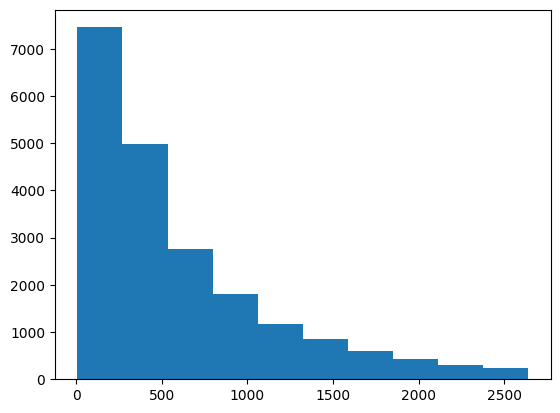

In [61]:
from matplotlib import pyplot as plt

plt.hist(text_per_row_length[text_per_row_length < max_seq_len])
plt.show()

In [13]:
df['text'][0]

'subject eastran nomin chang effect pleas decreas deliveri eastran mmbtu dy redeliveri well deliveri quantiti fuel cotton valley gas valu per paragraph contract price per mmbtu section transact agreement'

## Split train & test

Bagian ini digunakan untuk membagi dataset menjadi 2 bagian

In [1]:
import pandas as pd

df = pd.read_csv('../Datasets/EnronSpam/EnronSpam_after_preprocess.csv')
df

,text,label
0,subject eastran nomin chang effect pleas decre...,0
1,subject person inform need updat possibl first...,0
2,subject saudi arabia spoke mr maldinado morn l...,0
3,subject hpl nom may see attach file hplno xls ...,0
4,subject error repair jay june need coupl thing...,0
...,...,...
21691,subject paypal account temporarili disabl secu...,1
21692,subject keep immun system strong keep immun sy...,1
21693,subject need paliourg look fer v codin pi lls ...,1
21694,subject protect visa card send messag visa cre...,1


In [64]:
from sklearn.model_selection import train_test_split

data_train, data_to_predict = train_test_split(df, stratify=df['label'], train_size=0.5, random_state=42)

In [65]:
len(data_train.index)

10848

In [66]:
len(data_to_predict.index)

10848

## Test batch

Bagian ini digunakan untuk membagi data test ke beberapa batch dengan perbandingan kelas tetap (saat ini dibagi menjadi 10 batch)

In [67]:
data_to_predict.reset_index(inplace=True, drop=True)
data_to_predict['fold'] = None
NUMBER_SPLIT = 50

In [68]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=NUMBER_SPLIT, random_state=42, shuffle=True)

for fold, (train_index, test_index) in enumerate(skf.split(data_to_predict['text'], data_to_predict['label'])):
  data_to_predict.loc[test_index, 'fold'] = fold+1

In [69]:
for i in range(1, NUMBER_SPLIT+1):
  temp = data_to_predict[data_to_predict['fold'] == i]
  print('Fold {}:'.format(i))
  print(temp['label'].value_counts(normalize=True))
  print('total row: {}'.format(len(temp.index)))

Fold 1:
label
0    0.764977
1    0.235023
Name: proportion, dtype: float64
total row: 217
Fold 2:
label
0    0.764977
1    0.235023
Name: proportion, dtype: float64
total row: 217
Fold 3:
label
0    0.764977
1    0.235023
Name: proportion, dtype: float64
total row: 217
Fold 4:
label
0    0.764977
1    0.235023
Name: proportion, dtype: float64
total row: 217
Fold 5:
label
0    0.764977
1    0.235023
Name: proportion, dtype: float64
total row: 217
Fold 6:
label
0    0.764977
1    0.235023
Name: proportion, dtype: float64
total row: 217
Fold 7:
label
0    0.764977
1    0.235023
Name: proportion, dtype: float64
total row: 217
Fold 8:
label
0    0.764977
1    0.235023
Name: proportion, dtype: float64
total row: 217
Fold 9:
label
0    0.764977
1    0.235023
Name: proportion, dtype: float64
total row: 217
Fold 10:
label
0    0.764977
1    0.235023
Name: proportion, dtype: float64
total row: 217
Fold 11:
label
0    0.764977
1    0.235023
Name: proportion, dtype: float64
total row: 217
Fold 12:

# Feature extraction

word vectorization dilakukan dengan menggunakan TextVectorization layer dari tensor dengan metode 'int' (mirip seperti word count)

In [71]:
MAX_VOCAB = int(8e4)

## INT

In [82]:
import tensorflow as tf

vectorization_layer = tf.keras.layers.TextVectorization(
    standardize='lower',
    max_tokens=MAX_VOCAB,
    output_mode='int',
    output_sequence_length=max_seq_len,
    split='whitespace'
)

## TF-IDF

In [10]:
vectorization_layer = tf.keras.layers.TextVectorization(
    standardize='lower',
    max_tokens=MAX_VOCAB,
    output_mode='tf_idf',
    pad_to_max_tokens=True, 
    split='whitespace',
)

# Classes

In [73]:
class TensorFlowAdapter: # Kelas yang digunakan sebagai adapter untuk algoritma yang diimplementasi dari tensorflow
  def __init__(self, model, name):
    self.model = model
    self.name = name

    self.es = tf.keras.callbacks.EarlyStopping(monitor='precision', patience=3, mode='max', restore_best_weights=True)

  def predict(self, X):
    return self.model.predict(X).flatten()

  def fit(self, X_train, y_train, X_test, y_test):
    self.model.fit(X_train, y_train, epochs=100,
                  validation_data=(X_test, y_test),
                  callbacks=[self.es])

  def evaluate(self, X_test, y_test):
    _, accuracy, precision, recall = self.model.evaluate(X_test, y_test)
    return accuracy, precision, recall

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

class SklearnAdapter: # Kelas yang digunakan sebagai adapter untuk algoritma yang diimplementasi dari sklearn
  def __init__(self, model, name):
    self.model = model
    self.name = name

  def __vectorize_data(self, data):
    return vectorization_layer(data).numpy()

  def predict(self, X):
    X = self.__vectorize_data(X)
    return self.model.predict_proba(X)[:,1]

  def fit(self, X_train, y_train, X_test, y_test):
    X_train = self.__vectorize_data(X_train)
    self.model.fit(X_train, y_train)

  def evaluate(self, X_test, y_test):
    prediction = self.predict(X_test)
    prediction[prediction <= 0.7] = 0.
    prediction[prediction > 0.7] = 1.

    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)

    return accuracy, precision, recall

In [75]:
from scipy.stats import mode
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class SpamClassifier: # Kelas utama yang menampung ensemble classifier
  def __init__(self, data_train, data_to_predict, total_split, classifiers):
    self.data_train = data_train # data yang digunakan untuk proses training
    self.data_to_predict = data_to_predict # data yang digunakan untuk proses prediksi
    self.total_split = total_split # Jumlah batch data prediksi
    self.classifiers = classifiers # Variabel yang menampung algoritma-algoritma klasifikasi

    self.prediction_threshold = 0.7 # Threshold dalam menentukan kelas spam (> 0.7 berarti spam)
    self.evaluation = pd.DataFrame(columns=['Model', 'Iteration', 'Accuracy', 'Precision', 'Recall']) # Menampung history score tiap model sejauh iterasi

  def __split_train_data(self): # Method yang digunakan untuk membagi data train untuk proses training
    X = self.data_train['text'].values
    y = self.data_train['label'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=self.data_train['label'], train_size=0.7, random_state=42)

    return X_train, X_test, y_train, y_test

  def __get_data_to_predict(self, fold): # Method yang digunakan untuk mengambil data email yang akan diprediksi
    return self.data_to_predict[data_to_predict['fold'] == fold]['text'].values

  def __combine_data_train(self, X, y): # Method yang digunakan untuk menggabungkan data yang telah diprediksi dengan data train sebelumnya
    temp = pd.DataFrame({'text': X, 'label': y})
    self.data_train = pd.concat([self.data_train, temp], ignore_index=True)

  def __train_classifiers(self, X_train, X_test, y_train, y_test): # Method yang digunakan untuk melakukan train semua classifiers yang menyusun ensemble classifier
    for index in range(len(self.classifiers)):
      print(' Train {} model '.format(self.classifiers[index].name).center(30, '+'))
      self.classifiers[index].fit(X_train, y_train, X_test, y_test)

  def __evaluate_model(self, curr_split, X_test, y_test): # Method yang digunakan untuk mengambil evaluasi tiap model
    for index in range(len(self.classifiers)):
      print(' Evaluate {} model '.format(self.classifiers[index].name).center(30, '+'))
      accuracy, precision, recall = self.classifiers[index].evaluate(X_test, y_test)
      print('Accuracy: {} | Precision: {} | Recall: {}'.format(accuracy, precision, recall))
      curr_eval = pd.Series({'Model': self.classifiers[index].name, 'Iteration': curr_split, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall})
      self.evaluation = pd.concat([self.evaluation, curr_eval.to_frame().T], ignore_index=True)

  def __get_prediction(self, X): # Method yang digunakan untuk mendapatkan kelas prediksi
    raw_predictions = []
    for index in range(len(self.classifiers)):
      print(' Predicting using {} model '.format(self.classifiers[index].name).center(30, '-'))
      temp = self.classifiers[index].predict(X)
      temp[temp <= self.prediction_threshold] = 0
      temp[temp > self.prediction_threshold] = 1
      raw_predictions.append(temp)

    raw_predictions = np.stack((raw_predictions), axis=1)
    result = mode(raw_predictions, axis=-1, keepdims=False)
    return result.mode

  def execute(self): # Method utama untuk menjalankan skenario
    curr_split = 1
    while (curr_split <= self.total_split):
      print(' Processing Split {} '.format(curr_split).center(40, '#'))
      X_train, X_test, y_train, y_test = self.__split_train_data()
      vectorization_layer.adapt(X_train)
      print('Vocab len: {}'.format(len(vectorization_layer.get_vocabulary())))

      print(' Train models '.center(30, '-'))
      self.__train_classifiers(X_train, X_test, y_train, y_test)

      print(' Evaluate models '.center(30, '-'))
      self.__evaluate_model(curr_split, X_test, y_test)

      print(' Draw confusion matrix '.center(30, '-'))
      self.plot_confusion_matrix(X_test, y_test, curr_split)

      print(' Getting prediction '.center(30, '-'))
      X_predict = self.__get_data_to_predict(curr_split)
      prediction = self.__get_prediction(X_predict)


      print(' Combine data train with prediction '.center(30, '-'))
      total_row_before = len(self.data_train.index)
      self.__combine_data_train(X_predict, prediction)
      total_row_after = len(self.data_train.index)
      print('Total row before: {} | after: {}'.format(total_row_before, total_row_after))

      curr_split +=1

  def plot_confusion_matrix(self, X, y_true, iteration): # Method untuk menggambar confusion matrix
    y_pred = self.__get_prediction(X)
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=['false' ,'true']).plot()
    plt.title('Confusion Matrix for iteration: {}'.format(iteration))
    plt.show()
    # plt.savefig('evaluation/confusion_matrix/iteration_{}.png'.format(iteration))

# Skenario

In [76]:
def plot_graphs(metric, eval):
  plt.title(metric)
  for key in eval.keys():
    plt.plot(eval[key][metric])
  plt.xlabel('Iteration')
  plt.ylabel('Score')
  plt.legend(eval.keys())
  plt.show()

## Ensemble

### Model Initialization

In [24]:
classifiers = []

#### LSTM

In [17]:
def create_lstm_model(vect_layer):
  model = tf.keras.Sequential([
      vect_layer,
      tf.keras.layers.Embedding(
          input_dim=MAX_VOCAB,
          output_dim=64,
          mask_zero=True),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

  return model

In [ ]:
classifiers.append(TensorFlowAdapter(create_lstm_model(vectorization_layer), 'LSTM'))

#### DNN

In [18]:
def create_basic_nn_model(vect_layer):
  model = tf.keras.Sequential([
      vect_layer,
      tf.keras.layers.Embedding(
          input_dim=MAX_VOCAB,
          output_dim=64),
      # tf.keras.layers.Dropout(0.2),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='Recall')])

  return model

In [ ]:
classifiers.append(TensorFlowAdapter(create_basic_nn_model(vectorization_layer), 'DNN'))

#### SVM

In [ ]:
from sklearn.svm import SVC

classifiers.append(SklearnAdapter(SVC(random_state=42, probability=True), 'SVM'))

### Execution

In [30]:
spamClassifier = SpamClassifier(data_train, data_to_predict, NUMBER_SPLIT, classifiers)

In [31]:
spamClassifier.execute()

########## Processing Split 1 ##########


Vocab len: 43885
-------- Train models --------
++++++ Train LSTM model ++++++
Epoch 1/100
238/238 [==============================] - 4649s 19s/step - loss: 0.1849 - accuracy: 0.9264 - precision: 0.9386 - recall: 0.7382 - val_loss: 0.0610 - val_accuracy: 0.9788 - val_precision: 0.9607 - val_recall: 0.9495
Epoch 2/100
 12/238 [>.............................] - ETA: 1:17:41 - loss: 0.0225 - accuracy: 0.9948 - precision: 0.9891 - recall: 0.9891

In [ ]:
evaluation = spamClassifier.evaluation
per_model_eval = {}
for model in evaluation['Model'].values:
  per_model_eval[model] = evaluation[evaluation['Model'] == model].reset_index()

## Single

### Classifiers to check

In [85]:
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

classifiers = [
  SklearnAdapter(BernoulliNB(), 'Naive Bayes'),
  SklearnAdapter(KNeighborsClassifier(), 'k-NN'),
  SklearnAdapter(DecisionTreeClassifier(random_state=42), 'Decision Tree'),
  SklearnAdapter(RandomForestClassifier(random_state=42), 'Random Forest'),
  SklearnAdapter(SVC(random_state=42, probability=True), 'SVM'),
  # TensorFlowAdapter(create_basic_nn_model(vectorization_layer), 'DNN'),
  # TensorFlowAdapter(create_lstm_model(vectorization_layer), 'LSTM')
]

### Execute

~~~~~~~~~~~~~ Naive Bayes ~~~~~~~~~~~~~~
########## Processing Split 1 ##########


Vocab len: 43885
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.4261136712749616 | Precision: 0.2630895716140199 | Recall: 0.7865459249676585
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


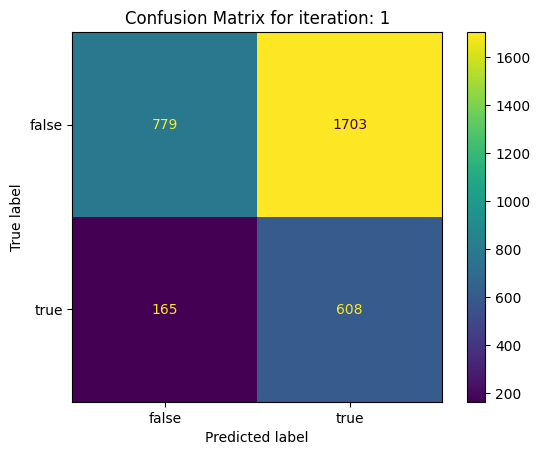

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 10848 | after: 11065
########## Processing Split 2 ##########
Vocab len: 44294
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.45481927710843373 | Precision: 0.27586206896551724 | Recall: 0.7396593673965937
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


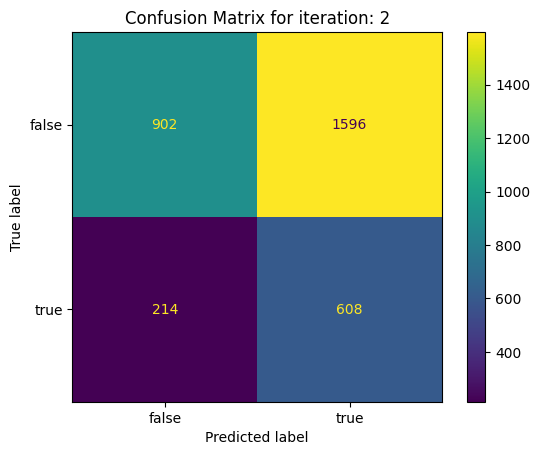

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 11065 | after: 11282
########## Processing Split 3 ##########
Vocab len: 44854
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.4573116691285081 | Precision: 0.28983634797588287 | Recall: 0.7816492450638792
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


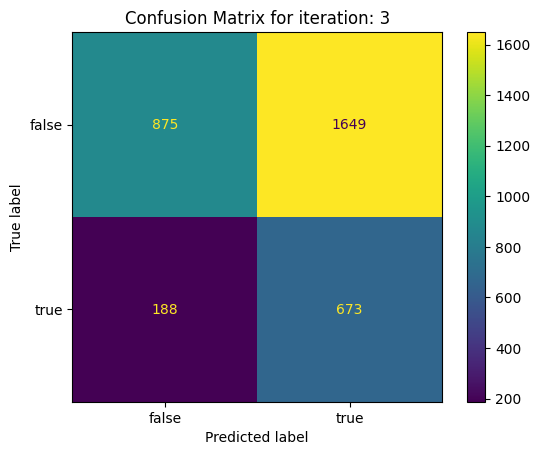

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 11282 | after: 11499
########## Processing Split 4 ##########
Vocab len: 45620
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.47333333333333333 | Precision: 0.3040103492884864 | Recall: 0.776431718061674
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


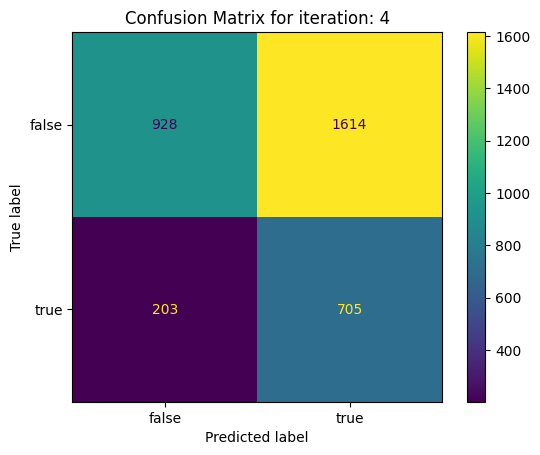

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 11499 | after: 11716
########## Processing Split 5 ##########
Vocab len: 46097
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.4904694167852063 | Precision: 0.3170731707317073 | Recall: 0.7655099894847529
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


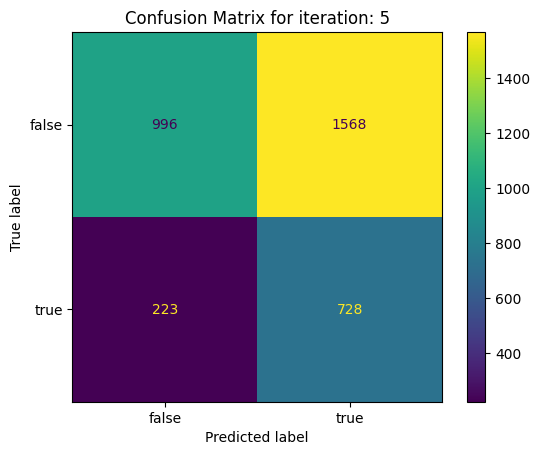

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 11716 | after: 11933
########## Processing Split 6 ##########
Vocab len: 46748
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.48854748603351955 | Precision: 0.3242220353238015 | Recall: 0.7748743718592965
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


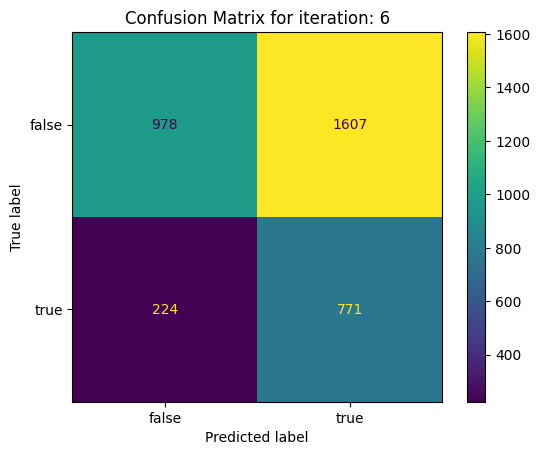

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 11933 | after: 12150
########## Processing Split 7 ##########
Vocab len: 47657
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5034293552812071 | Precision: 0.34049586776859503 | Recall: 0.7938342967244701
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


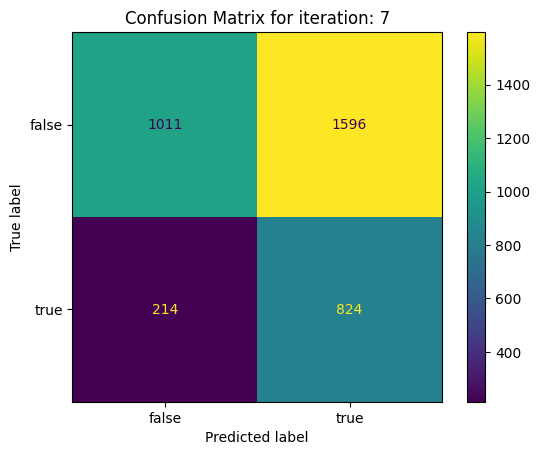

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 12150 | after: 12367
########## Processing Split 8 ##########
Vocab len: 47928
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5082188089463756 | Precision: 0.3483791546983997 | Recall: 0.7817679558011049
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


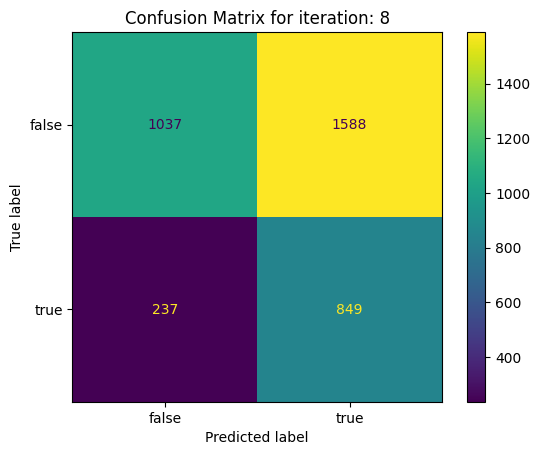

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 12367 | after: 12584
########## Processing Split 9 ##########
Vocab len: 48294
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5180084745762712 | Precision: 0.3578169881001231 | Recall: 0.7737355811889973
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


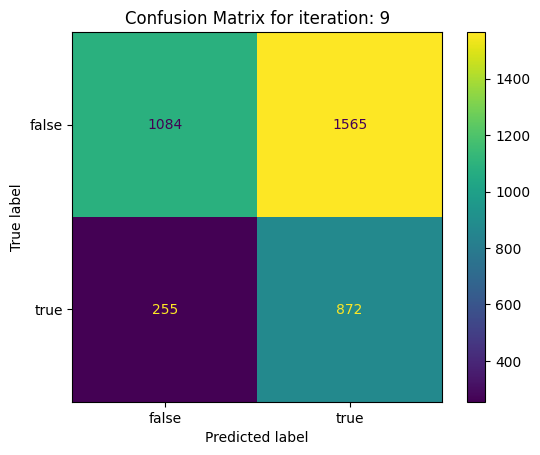

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 12584 | after: 12801
######### Processing Split 10 ##########
Vocab len: 47878
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5316323873991148 | Precision: 0.3710921640276086 | Recall: 0.7852233676975945
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


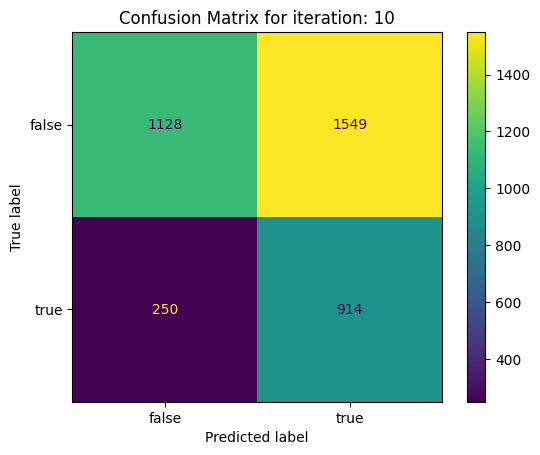

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 12801 | after: 13018
######### Processing Split 11 ##########
Vocab len: 50154
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5343061955965182 | Precision: 0.37902592301649646 | Recall: 0.802161263507897
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


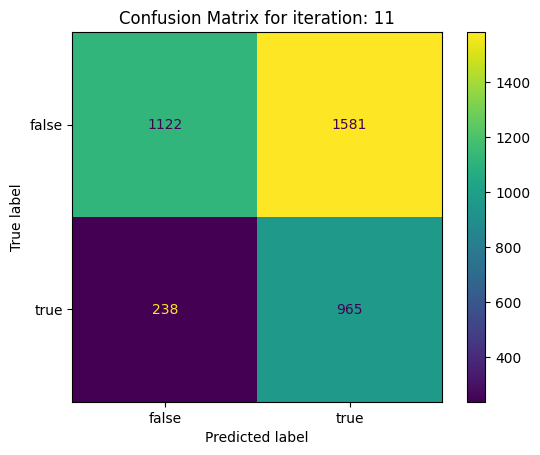

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 13018 | after: 13235
######### Processing Split 12 ##########
Vocab len: 50873
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5346260387811634 | Precision: 0.3841440061279203 | Recall: 0.8069187449718423
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


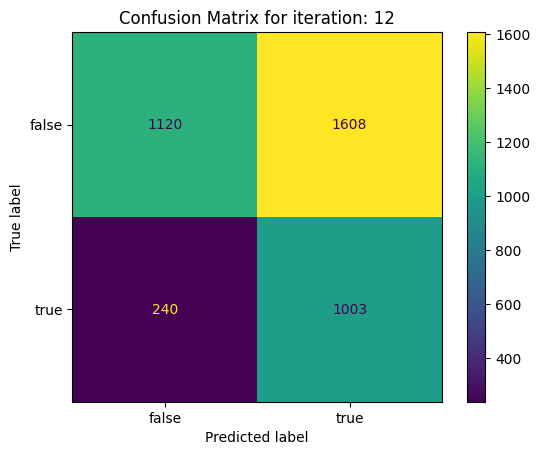

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 13235 | after: 13452
######### Processing Split 13 ##########
Vocab len: 51715
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5450941526263627 | Precision: 0.3958412098298677 | Recall: 0.8147859922178988
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


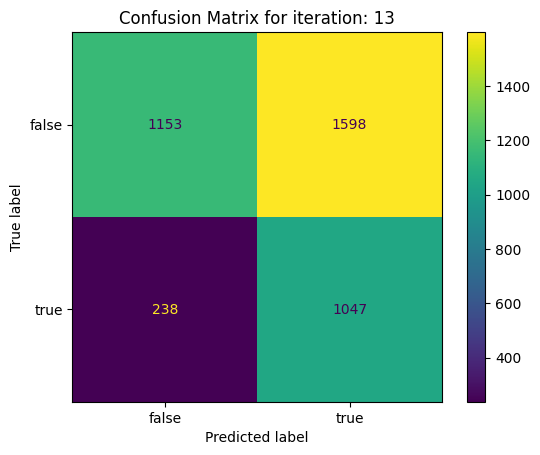

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 13452 | after: 13669
######### Processing Split 14 ##########
Vocab len: 51098
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5542550597415264 | Precision: 0.4057207376740685 | Recall: 0.8123587038432555
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


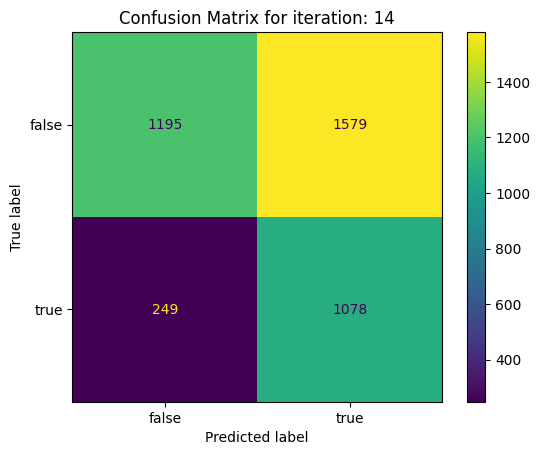

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 13669 | after: 13886
######### Processing Split 15 ##########
Vocab len: 50498
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5516082573211714 | Precision: 0.40860610518573004 | Recall: 0.8103574033552152
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


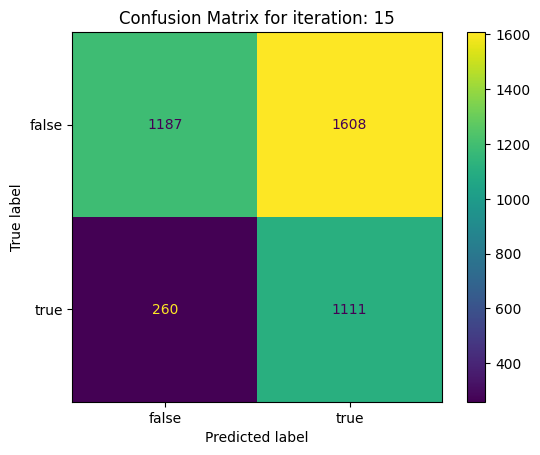

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 13886 | after: 14103
######### Processing Split 16 ##########
Vocab len: 50861
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.558733160009454 | Precision: 0.4173313995649021 | Recall: 0.8157335223245925
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


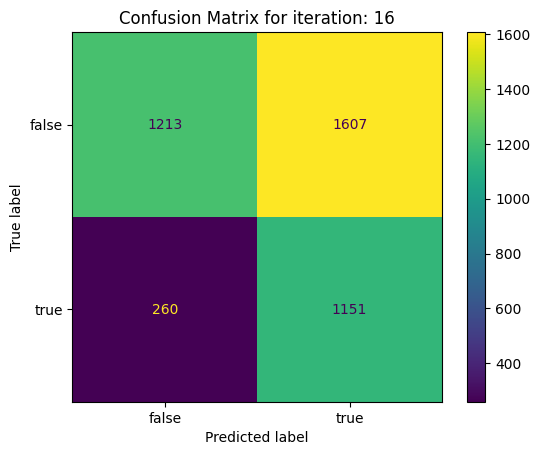

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 14103 | after: 14320
######### Processing Split 17 ##########
Vocab len: 51651
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5700651769087524 | Precision: 0.4303931987247609 | Recall: 0.8356258596973866
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


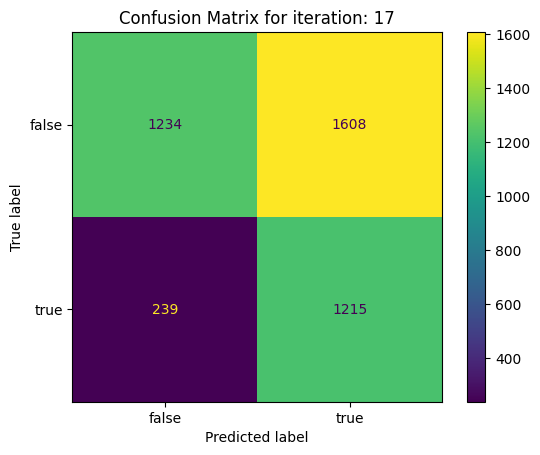

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 14320 | after: 14537
######### Processing Split 18 ##########
Vocab len: 52215
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5754241173773499 | Precision: 0.4390328151986183 | Recall: 0.847898599066044
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


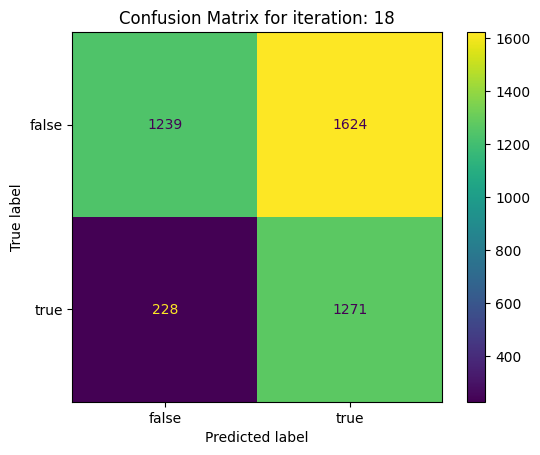

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 14537 | after: 14754
######### Processing Split 19 ##########
Vocab len: 52684
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5827874407047662 | Precision: 0.4473051836594576 | Recall: 0.8461038961038961
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


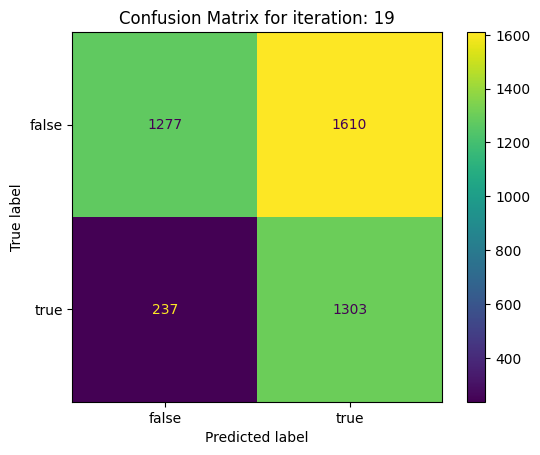

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 14754 | after: 14971
######### Processing Split 20 ##########
Vocab len: 54236
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5843722172751559 | Precision: 0.45270952541231907 | Recall: 0.8480453972257251
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


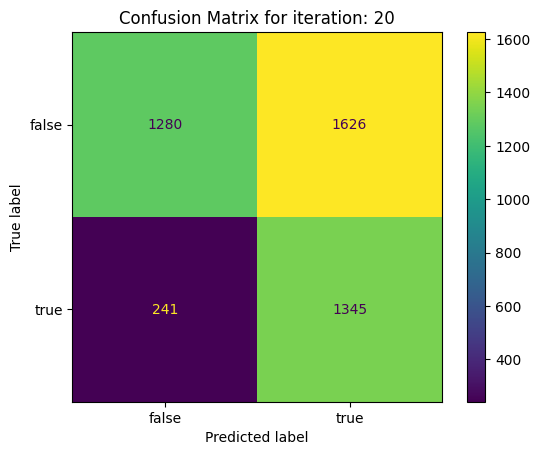

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 14971 | after: 15188
######### Processing Split 21 ##########
Vocab len: 54561
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5903006363835857 | Precision: 0.4609012591119947 | Recall: 0.8528510116492949
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


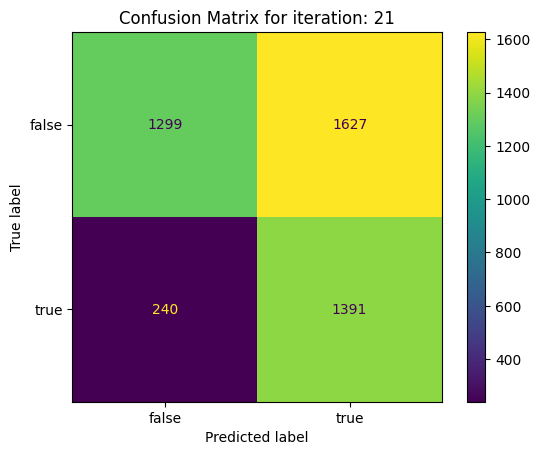

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 15188 | after: 15405
######### Processing Split 22 ##########
Vocab len: 55053
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.5943314582431848 | Precision: 0.4674730304020922 | Recall: 0.8532219570405728
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


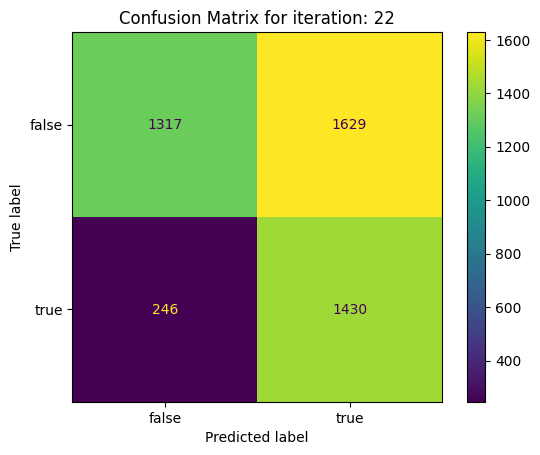

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 15405 | after: 15622
######### Processing Split 23 ##########
Vocab len: 55406
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6005973970556859 | Precision: 0.47551546391752575 | Recall: 0.858139534883721
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


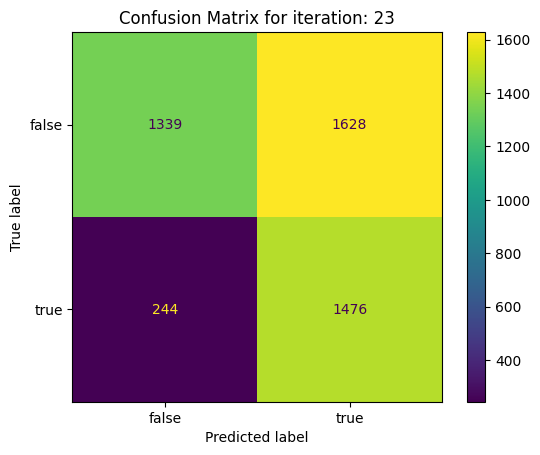

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 15622 | after: 15839
######### Processing Split 24 ##########
Vocab len: 55546
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6054292929292929 | Precision: 0.48281349458943346 | Recall: 0.8585172608941709
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


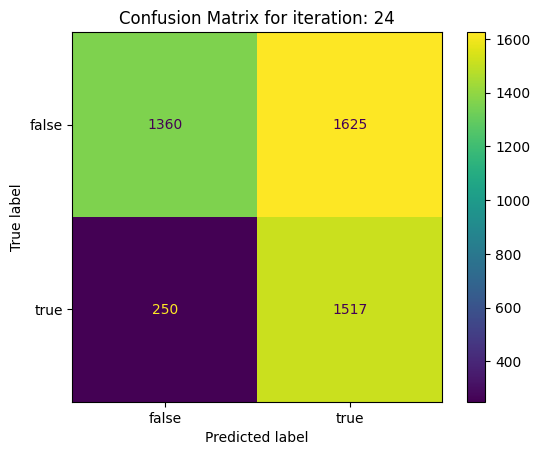

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 15839 | after: 16056
######### Processing Split 25 ##########
Vocab len: 54128
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6080548058957858 | Precision: 0.4878125 | Recall: 0.8624309392265194
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


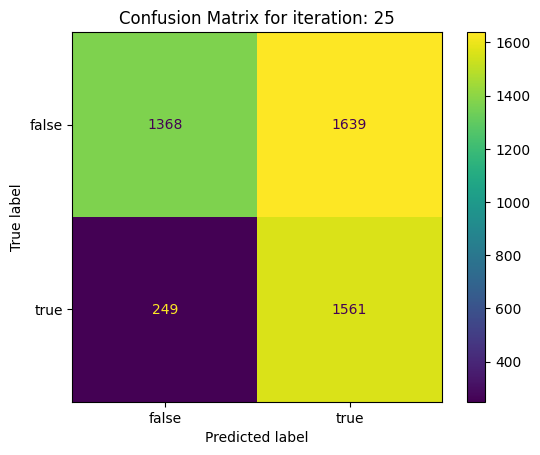

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 16056 | after: 16273
######### Processing Split 26 ##########
Vocab len: 55520
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6061040557148709 | Precision: 0.4887057387057387 | Recall: 0.8658734451054624
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


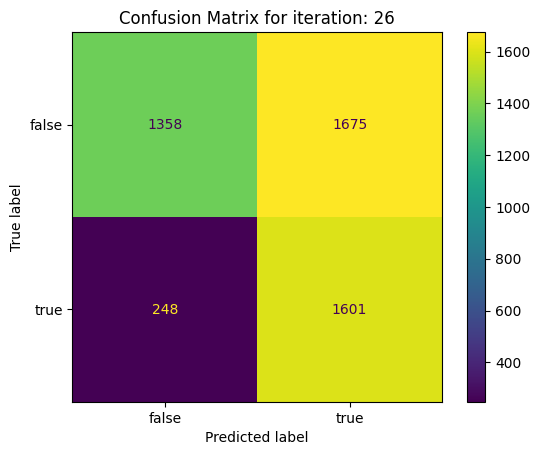

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 16273 | after: 16490
######### Processing Split 27 ##########
Vocab len: 54558
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6189609864564383 | Precision: 0.5019798964361865 | Recall: 0.8682824025289779
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


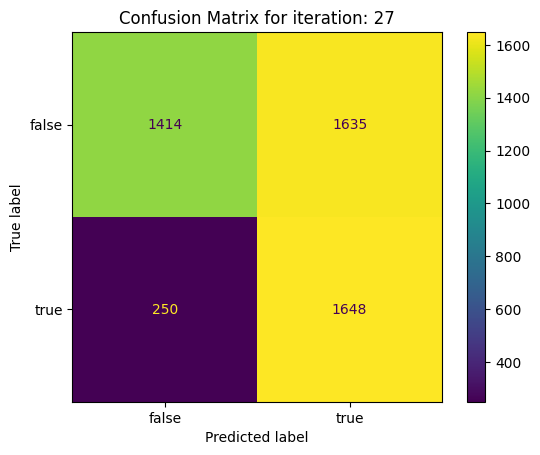

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 16490 | after: 16707
######### Processing Split 28 ##########
Vocab len: 55404
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6229802513464991 | Precision: 0.5075301204819277 | Recall: 0.8685567010309279
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


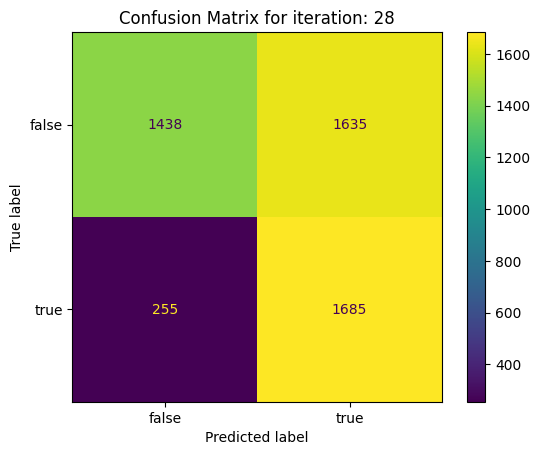

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 16707 | after: 16924
######### Processing Split 29 ##########
Vocab len: 55936
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6289877904686885 | Precision: 0.5148986889153755 | Recall: 0.8709677419354839
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


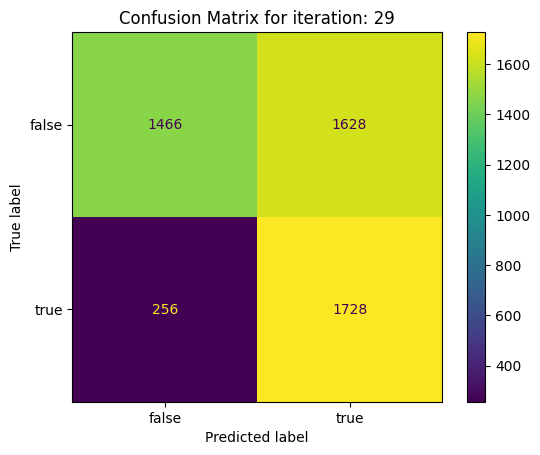

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 16924 | after: 17141
######### Processing Split 30 ##########
Vocab len: 56383
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6286214271825783 | Precision: 0.5172615564657694 | Recall: 0.8717948717948718
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


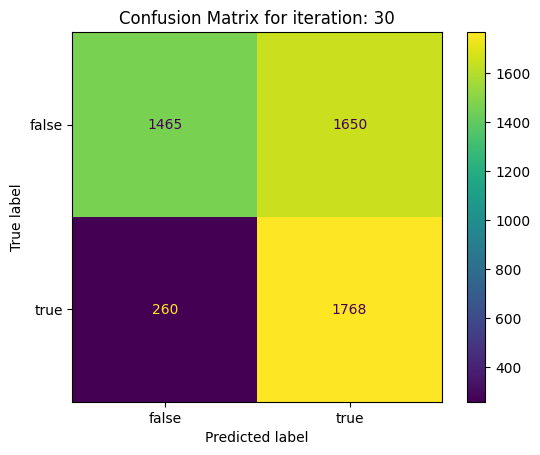

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 17141 | after: 17358
######### Processing Split 31 ##########
Vocab len: 57200
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6336405529953917 | Precision: 0.5240023134759977 | Recall: 0.8736740597878495
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


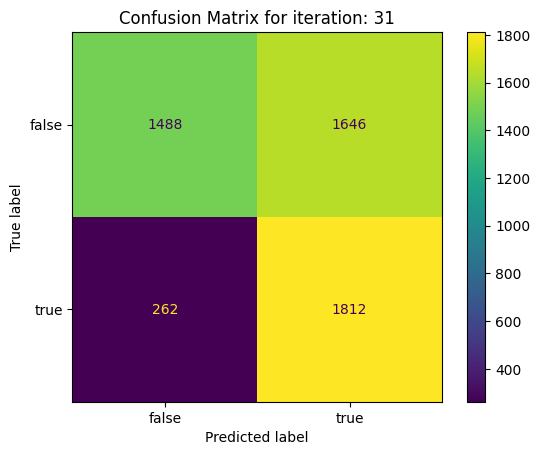

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 17358 | after: 17575
######### Processing Split 32 ##########
Vocab len: 56645
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6358809027119287 | Precision: 0.5281730221969266 | Recall: 0.8762983947119924
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


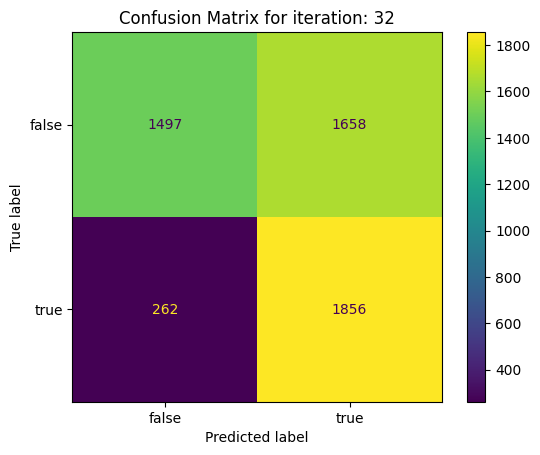

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 17575 | after: 17792
######### Processing Split 33 ##########
Vocab len: 57661
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6388160359685275 | Precision: 0.5328855303666387 | Recall: 0.8802588996763754
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


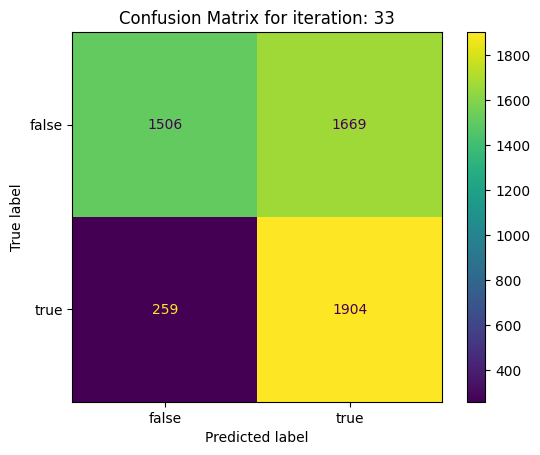

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 17792 | after: 18009
######### Processing Split 34 ##########
Vocab len: 56809
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6440866185452526 | Precision: 0.5393755180989224 | Recall: 0.8840579710144928
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


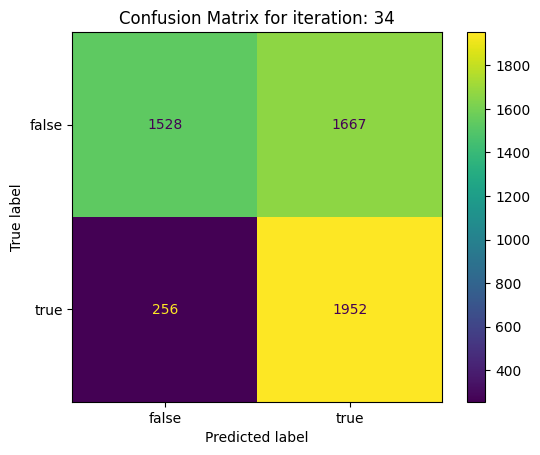

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 18009 | after: 18226
######### Processing Split 35 ##########
Vocab len: 58107
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6466715435259692 | Precision: 0.5430517711171662 | Recall: 0.8865658362989324
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


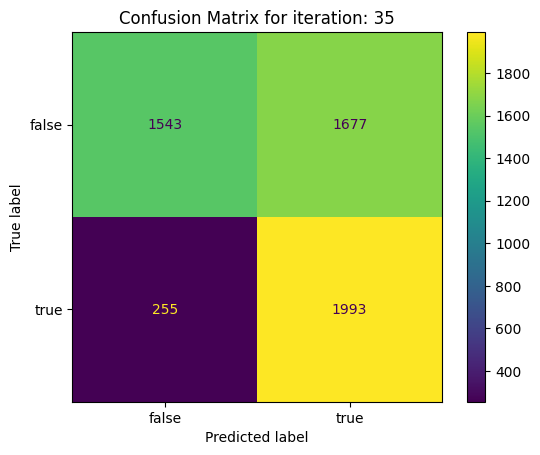

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 18226 | after: 18443
######### Processing Split 36 ##########
Vocab len: 58761
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6506416049159588 | Precision: 0.5488559892328398 | Recall: 0.8880662020905923
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


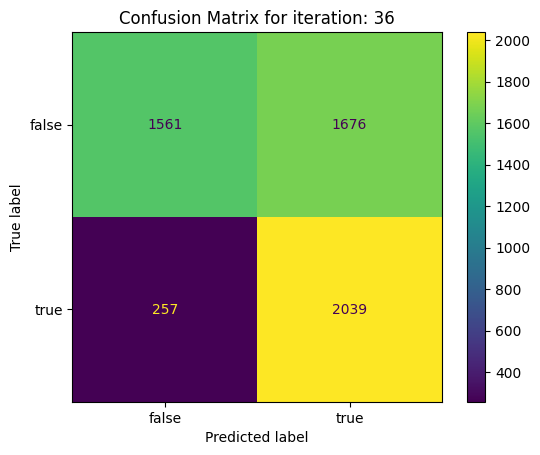

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 18443 | after: 18660
######### Processing Split 37 ##########
Vocab len: 58479
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6563058235083958 | Precision: 0.5558213716108453 | Recall: 0.8920648464163823
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


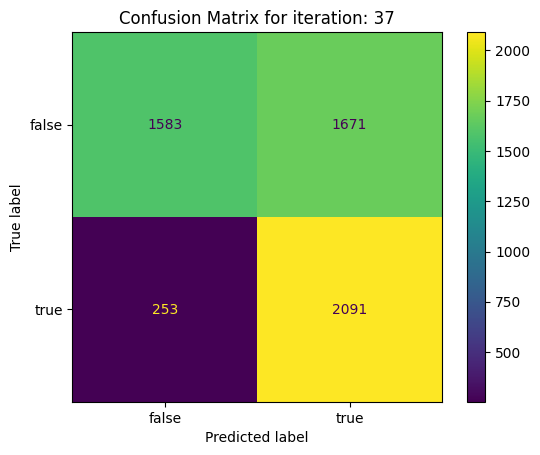

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 18660 | after: 18877
######### Processing Split 38 ##########
Vocab len: 58831
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6620762711864406 | Precision: 0.5627306273062731 | Recall: 0.893305439330544
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


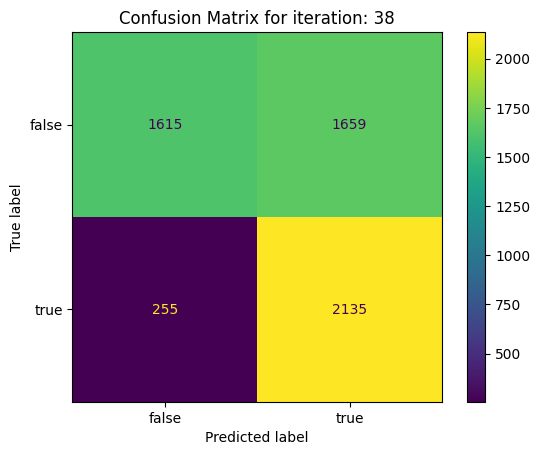

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 18877 | after: 19094
######### Processing Split 39 ##########
Vocab len: 59947
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6660848315587362 | Precision: 0.567539538501426 | Recall: 0.899342645850452
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


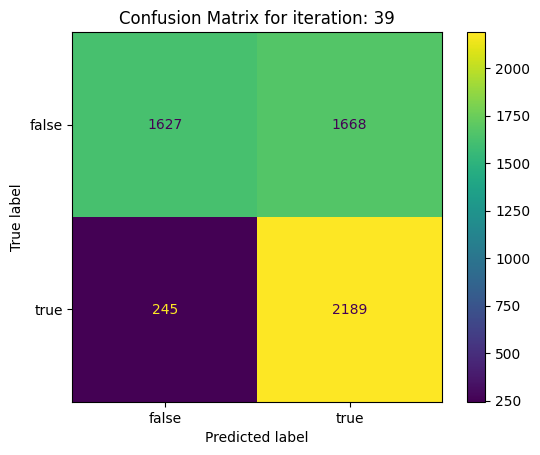

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 19094 | after: 19311
######### Processing Split 40 ##########
Vocab len: 59423
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6681049361408353 | Precision: 0.5710633946830266 | Recall: 0.9011698265429609
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


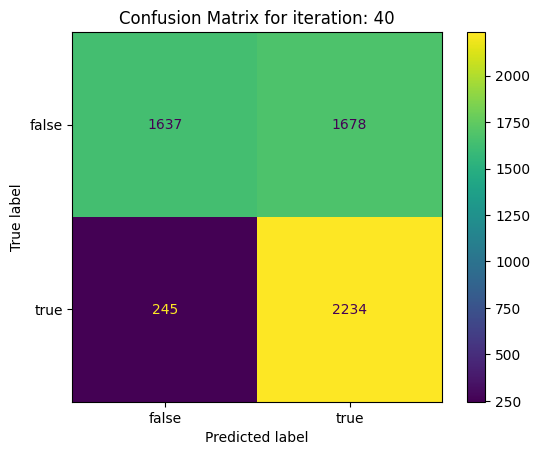

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 19311 | after: 19528
######### Processing Split 41 ##########
Vocab len: 58772
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6716163167776071 | Precision: 0.5760182140146723 | Recall: 0.9017821782178218
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


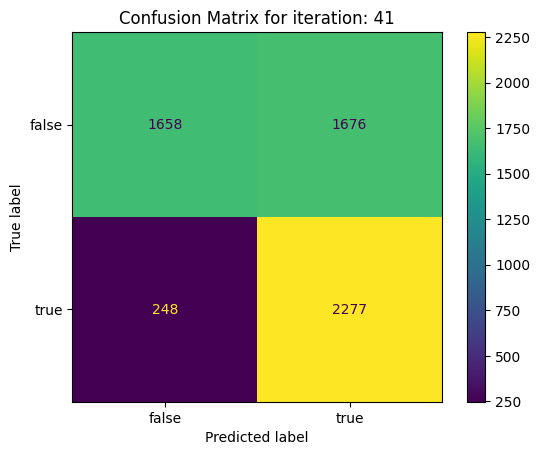

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 19528 | after: 19745
######### Processing Split 42 ##########
Vocab len: 58882
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6737002025658338 | Precision: 0.5789342629482072 | Recall: 0.905726529022205
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


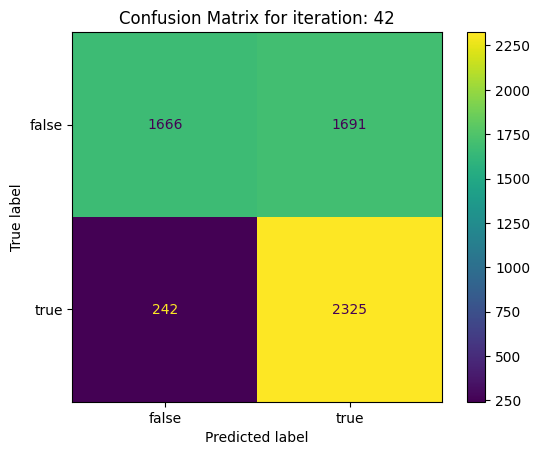

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 19745 | after: 19962
######### Processing Split 43 ##########
Vocab len: 59827
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6780764735348138 | Precision: 0.5845734126984127 | Recall: 0.9030651340996169
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


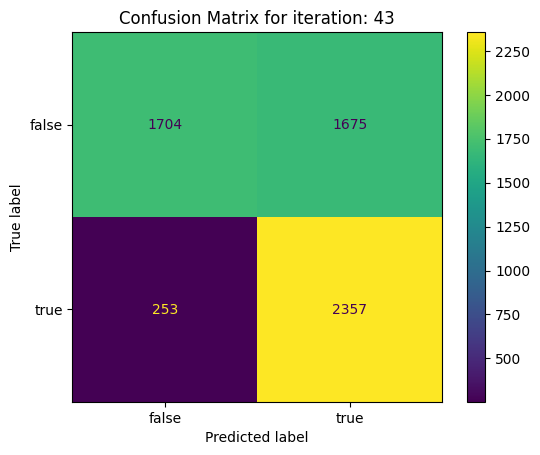

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 19962 | after: 20179
######### Processing Split 44 ##########
Vocab len: 59367
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6818632309217046 | Precision: 0.5890578999018645 | Recall: 0.9053544494720965
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


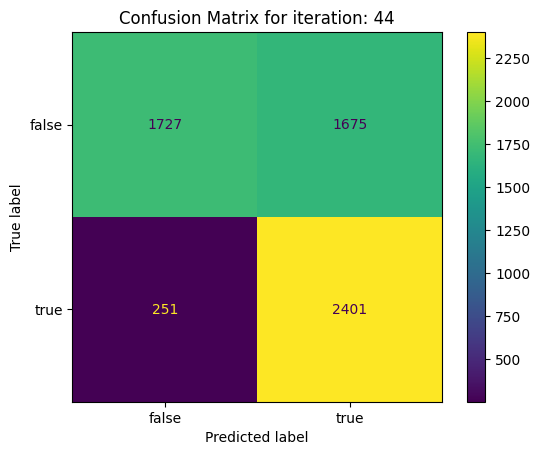

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 20179 | after: 20396
######### Processing Split 45 ##########
Vocab len: 61420
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6839352835430625 | Precision: 0.5920734654422426 | Recall: 0.908753709198813
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


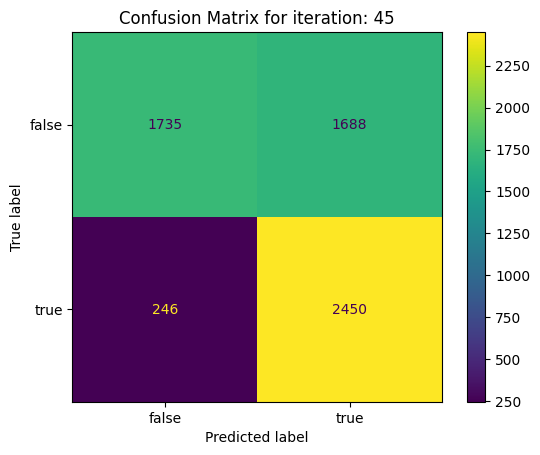

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 20396 | after: 20613
######### Processing Split 46 ##########
Vocab len: 61316
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.689359637774903 | Precision: 0.5984176456485255 | Recall: 0.9102844638949672
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


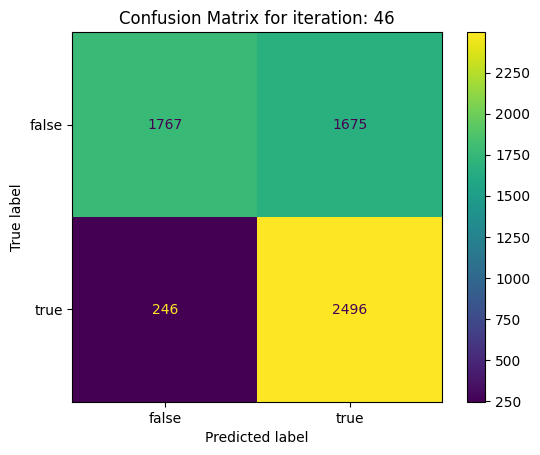

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 20613 | after: 20830
######### Processing Split 47 ##########
Vocab len: 61816
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.69248 | Precision: 0.6028015194681862 | Recall: 0.9106886657101865
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


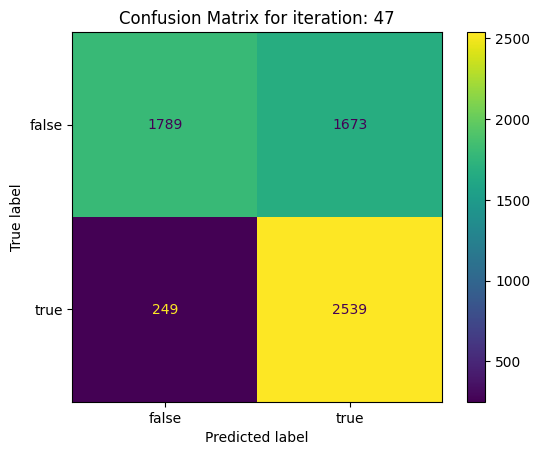

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 20830 | after: 21047
######### Processing Split 48 ##########
Vocab len: 61907
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6912114014251781 | Precision: 0.6027014438751747 | Recall: 0.9138418079096046
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


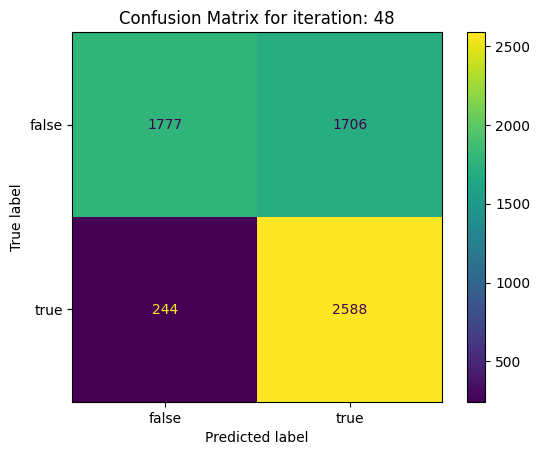

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 21047 | after: 21264
######### Processing Split 49 ##########
Vocab len: 62850
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6973354231974922 | Precision: 0.6094510076441974 | Recall: 0.9148122392211405
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


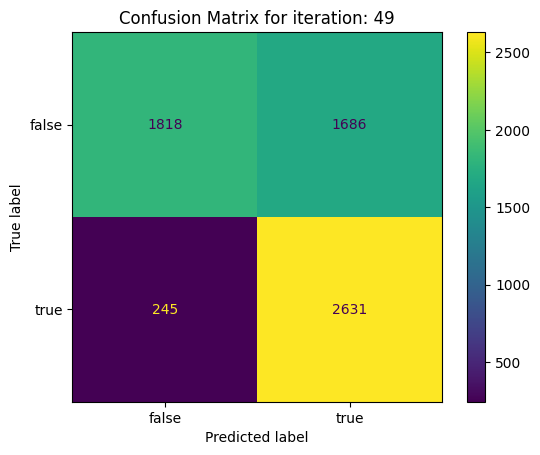

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 21264 | after: 21480
######### Processing Split 50 ##########
Vocab len: 62828
-------- Train models --------
++ Train Naive Bayes model +++
------ Evaluate models -------
+ Evaluate Naive Bayes model +
Accuracy: 0.6991466252909232 | Precision: 0.6124742031644118 | Recall: 0.9147260273972603
--- Draw confusion matrix ----
 Predicting using Naive Bayes model 


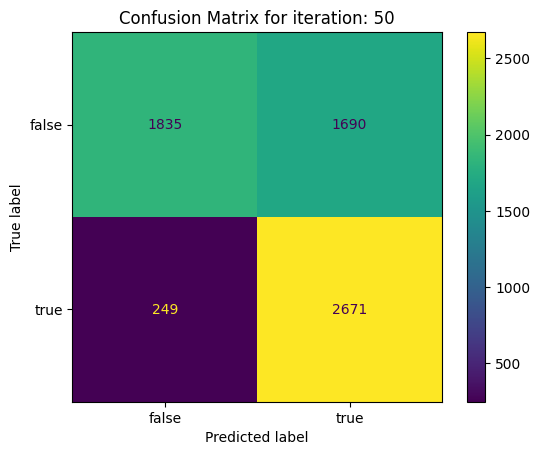

----- Getting prediction -----
 Predicting using Naive Bayes model 
 Combine data train with prediction 
Total row before: 21480 | after: 21696


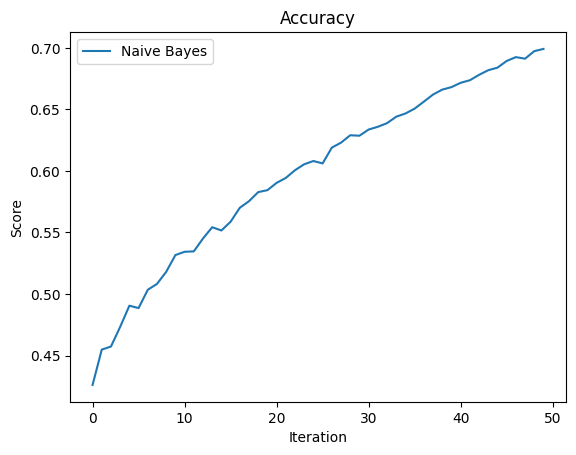

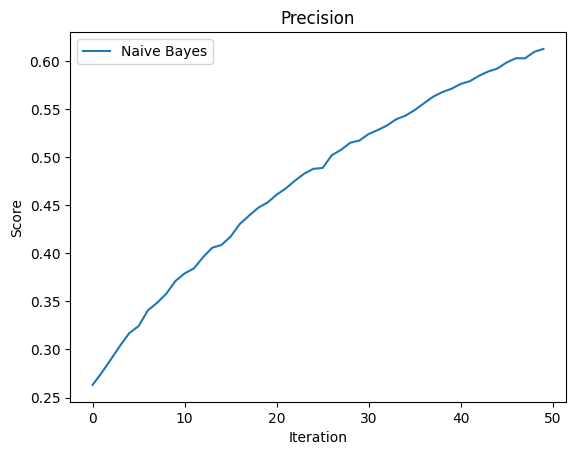

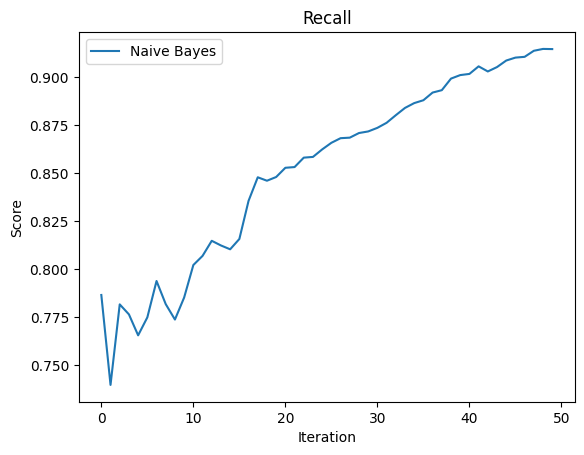

~~~~~~~~~~~~~~~~~ k-NN ~~~~~~~~~~~~~~~~~
########## Processing Split 1 ##########
Vocab len: 43885
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.7788018433179723 | Precision: 0.7572815533980582 | Recall: 0.10090556274256145
--- Draw confusion matrix ----
 Predicting using k-NN model -


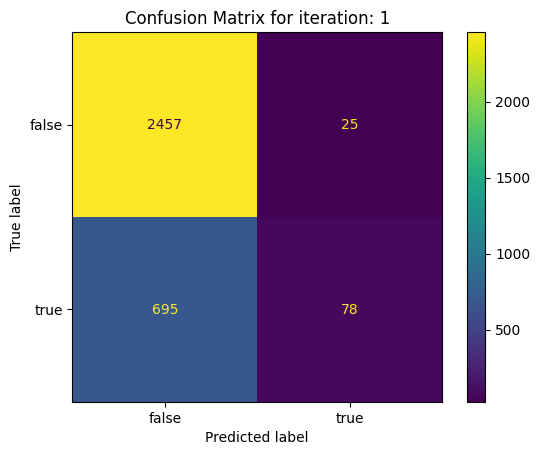

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 10848 | after: 11065
########## Processing Split 2 ##########
Vocab len: 44040
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.7870481927710843 | Precision: 0.8130841121495327 | Recall: 0.1124031007751938
--- Draw confusion matrix ----
 Predicting using k-NN model -


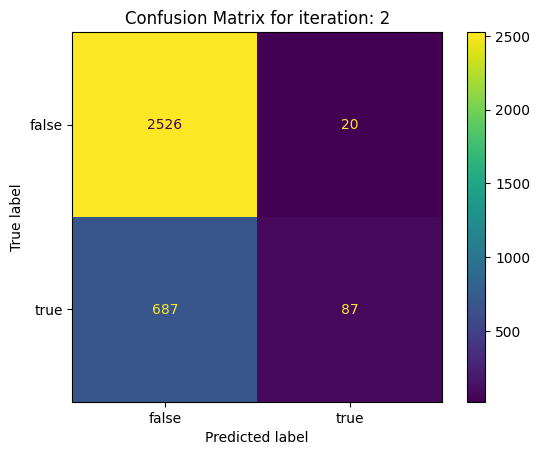

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 11065 | after: 11282
########## Processing Split 3 ##########
Vocab len: 44686
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.7884785819793205 | Precision: 0.7727272727272727 | Recall: 0.1095360824742268
--- Draw confusion matrix ----
 Predicting using k-NN model -


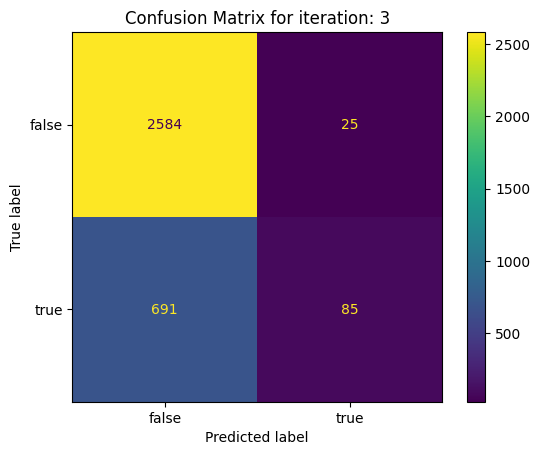

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 11282 | after: 11499
########## Processing Split 4 ##########
Vocab len: 45258
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.7910144927536232 | Precision: 0.8222222222222222 | Recall: 0.09499358151476252
--- Draw confusion matrix ----
 Predicting using k-NN model -


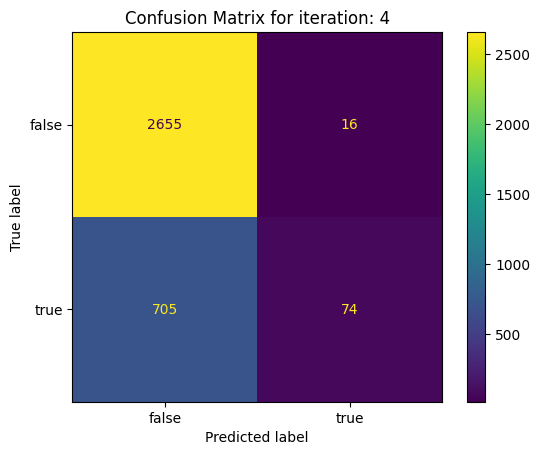

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 11499 | after: 11716
########## Processing Split 5 ##########
Vocab len: 46610
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.8 | Precision: 0.8823529411764706 | Recall: 0.11523687580025609
--- Draw confusion matrix ----
 Predicting using k-NN model -


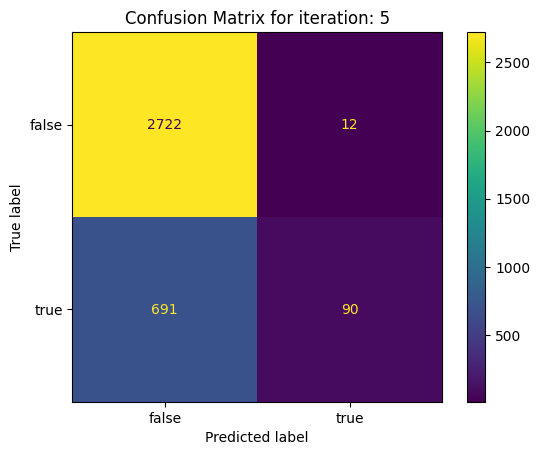

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 11716 | after: 11933
########## Processing Split 6 ##########
Vocab len: 47415
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.7994413407821229 | Precision: 0.8404255319148937 | Recall: 0.1010230179028133
--- Draw confusion matrix ----
 Predicting using k-NN model -


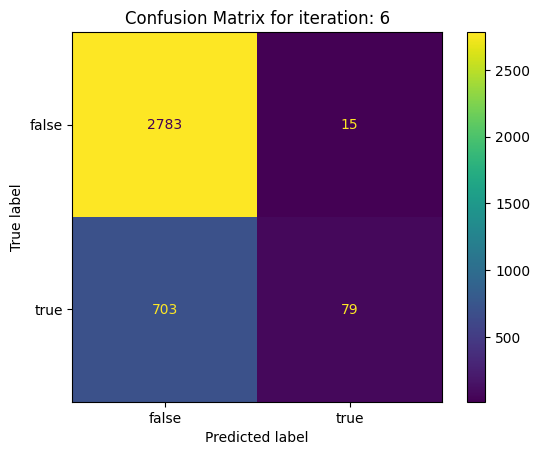

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 11933 | after: 12150
########## Processing Split 7 ##########
Vocab len: 47471
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.8016460905349794 | Precision: 0.8279569892473119 | Recall: 0.09821428571428571
--- Draw confusion matrix ----
 Predicting using k-NN model -


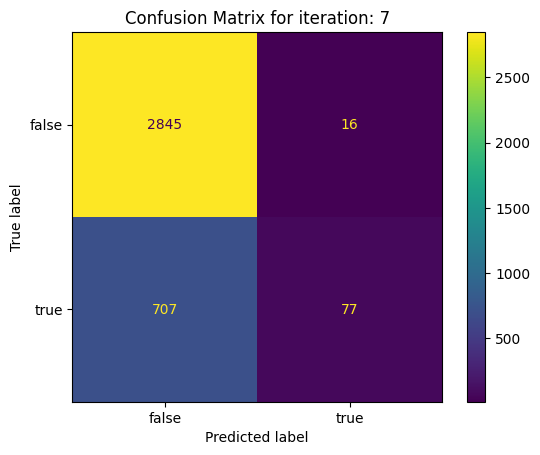

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 12150 | after: 12367
########## Processing Split 8 ##########
Vocab len: 46702
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.8057127458905955 | Precision: 0.8555555555555555 | Recall: 0.0980891719745223
--- Draw confusion matrix ----
 Predicting using k-NN model -


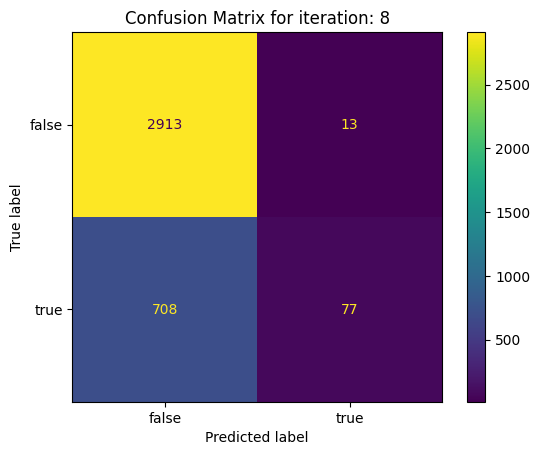

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 12367 | after: 12584
########## Processing Split 9 ##########
Vocab len: 46689
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.8061440677966102 | Precision: 0.7894736842105263 | Recall: 0.09529860228716645
--- Draw confusion matrix ----
 Predicting using k-NN model -


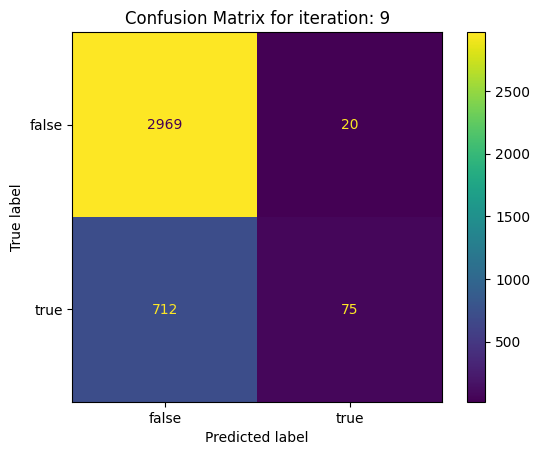

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 12584 | after: 12801
######### Processing Split 10 ##########
Vocab len: 47089
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.8073418380630044 | Precision: 0.7816091954022989 | Recall: 0.08618504435994931
--- Draw confusion matrix ----
 Predicting using k-NN model -


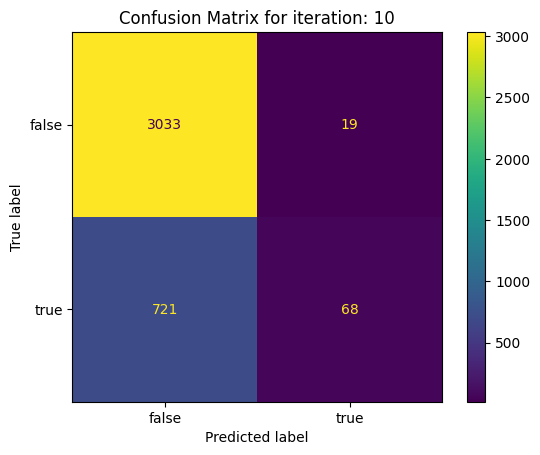

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 12801 | after: 13018
######### Processing Split 11 ##########
Vocab len: 48418
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.8125960061443932 | Precision: 0.8020833333333334 | Recall: 0.09746835443037975
--- Draw confusion matrix ----
 Predicting using k-NN model -


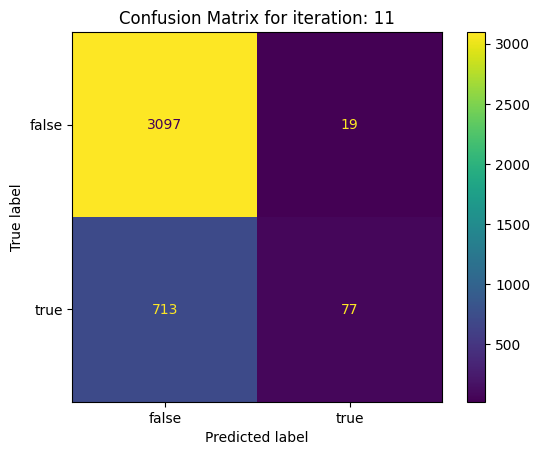

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 13018 | after: 13235
######### Processing Split 12 ##########
Vocab len: 49834
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.820700075547721 | Precision: 0.8623853211009175 | Recall: 0.11883691529709228
--- Draw confusion matrix ----
 Predicting using k-NN model -


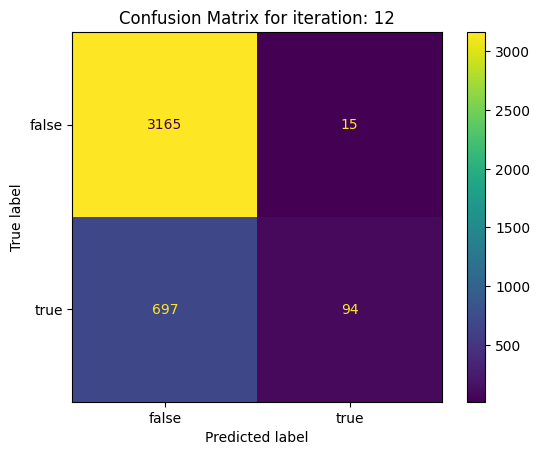

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 13235 | after: 13452
######### Processing Split 13 ##########
Vocab len: 48702
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.8159068384539148 | Precision: 0.7816091954022989 | Recall: 0.08585858585858586
--- Draw confusion matrix ----
 Predicting using k-NN model -


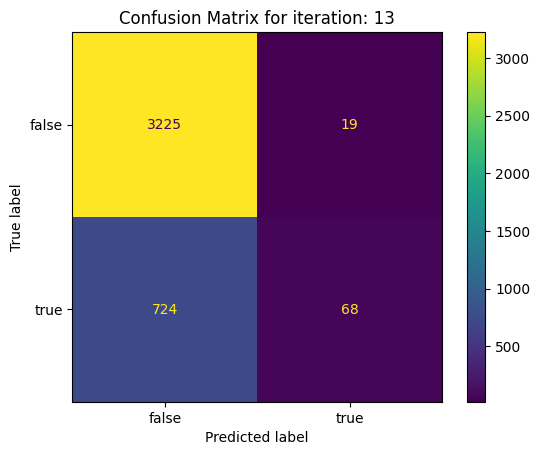

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 13452 | after: 13669
######### Processing Split 14 ##########
Vocab len: 49785
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.8227261643501586 | Precision: 0.8316831683168316 | Recall: 0.10579345088161209
--- Draw confusion matrix ----
 Predicting using k-NN model -


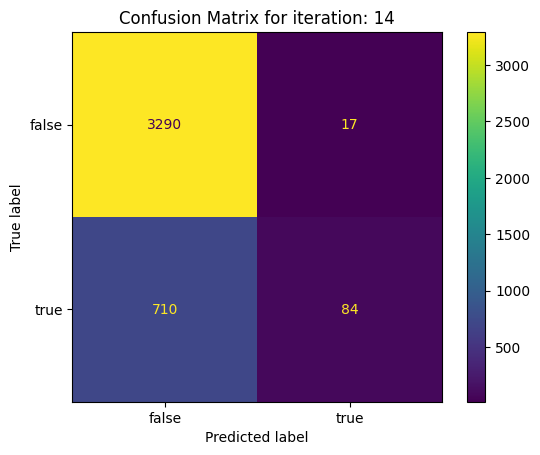

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 13669 | after: 13886
######### Processing Split 15 ##########
Vocab len: 49853
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.8226116178588574 | Precision: 0.7857142857142857 | Recall: 0.09685534591194969
--- Draw confusion matrix ----
 Predicting using k-NN model -


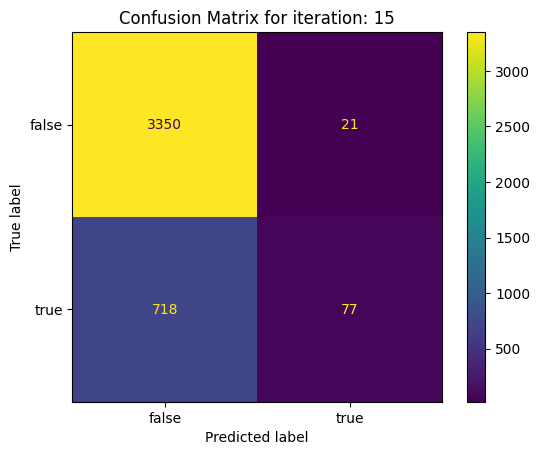

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 13886 | after: 14103
######### Processing Split 16 ##########
Vocab len: 51176
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.8241550460883952 | Precision: 0.8117647058823529 | Recall: 0.08657465495608532
--- Draw confusion matrix ----
 Predicting using k-NN model -


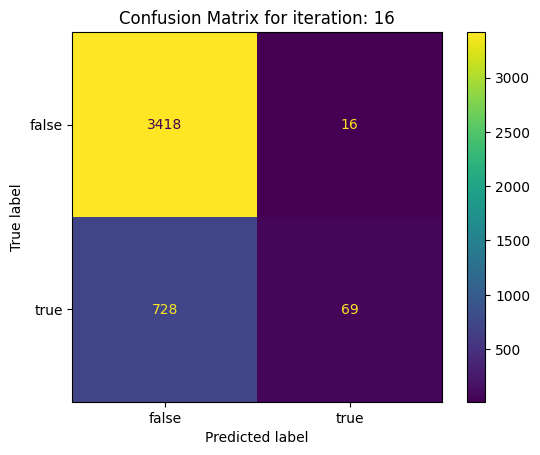

----- Getting prediction -----
 Predicting using k-NN model -
 Combine data train with prediction 
Total row before: 14103 | after: 14320
######### Processing Split 17 ##########
Vocab len: 50606
-------- Train models --------
++++++ Train k-NN model ++++++
------ Evaluate models -------
++++ Evaluate k-NN model +++++
Accuracy: 0.8272811918063314 | Precision: 0.7614678899082569 | Recall: 0.10387984981226533
--- Draw confusion matrix ----
 Predicting using k-NN model -


KeyboardInterrupt: 

In [86]:
for classifier in classifiers:
  print(' {} '.format(classifier.name).center(40, '~'))
  spamClassifier = SpamClassifier(data_train, data_to_predict, NUMBER_SPLIT, [classifier])
  spamClassifier.execute()

  evaluation = spamClassifier.evaluation
  model_eval = {}
  for model in evaluation['Model'].values:
    model_eval[model] = evaluation[evaluation['Model'] == model].reset_index() 
    model_eval[model].to_csv('../Result/SingleLearning/int/2/{}_score.csv'.format(model))

  plot_graphs('Accuracy', model_eval)
  plot_graphs('Precision', model_eval)
  plot_graphs('Recall', model_eval)